## Optimise clustering analysis hyperparameters using grid search

Author: Katharine Leney, April 2025

In [1]:
import itertools
import os
import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
import hdbscan
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import sys
sys.path.append("../src")
from utils.stopwords import CUSTOM_STOPWORDS

/Users/katharine/anaconda3/envs/iata/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
with open("../data/chunks.json") as f:
    data = json.load(f)

texts = [entry["text"] for entry in data]

# Make sure the models folder exists
os.makedirs("../models", exist_ok=True)
os.makedirs("../models/hp_optimisation", exist_ok=True)

In [ ]:
# Allow any word‐ or hyphen‐chars, length ≥2, but require at least one letter
token_pattern = r"(?u)\b(?=\w*[A-Za-z])[\w-]{2,}\b"

custom_vectorizer = CountVectorizer(
    stop_words=CUSTOM_STOPWORDS, # Remove stopwords (set in src/stopwords.py)
    ngram_range=(1, 2),          # Include unigrams and bigrams
    token_pattern=token_pattern
)

In [4]:
# Lightweight sentence transformer from Hugging Face
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
# Turns sentences into dense vectors 
# https://medium.com/@yasindusanjeewa8/dense-vectors-in-natural-language-processing-06818dff5cd7

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [5]:
# ------------------------------------------------------------
# Define Grid Search Parameters
# ------------------------------------------------------------
n_neighbors_grid = [5, 10, 15]
min_cluster_size_grid = [10, 15, 20, 25, 30]
model_dir = "../models/hp_optimisation/"
os.makedirs(model_dir, exist_ok=True)
random_state = 42

In [6]:
# ------------------------------------------------------------
# Grid Search Loop
# ------------------------------------------------------------
results = []

for n_neighbors, min_cluster_size in itertools.product(n_neighbors_grid, min_cluster_size_grid):
    print(f"Training model with n_neighbors={n_neighbors}, min_cluster_size={min_cluster_size}")

    umap_model = UMAP(
        n_neighbors=n_neighbors,
        n_components=5,
        min_dist=0.0,
        metric="cosine",
        random_state=random_state
    )

    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=5,
        metric="euclidean",
        cluster_selection_method="eom",
        prediction_data=True
    )

    topic_model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=custom_vectorizer,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        calculate_probabilities=True,
        verbose=True
    )

    topics, probs = topic_model.fit_transform(texts)
    n_topics = len(set(t for t in topics if t != -1))

    timestamp = datetime.datetime.now().strftime("%Y%m%d")
    model_name = f"bertopic_neighbors{n_neighbors}_cluster{min_cluster_size}_{timestamp}"
    topic_model.save(os.path.join(model_dir, model_name))

    results.append({
        "model_name": model_name,
        "n_neighbors": n_neighbors,
        "min_cluster_size": min_cluster_size,
        "n_topics": n_topics
    })

    print(f"Saved {model_name} with {n_topics} topics.")

2025-04-28 18:28:27,010 - BERTopic - Embedding - Transforming documents to embeddings.


Training model with n_neighbors=5, min_cluster_size=10


Batches: 100%|██████████| 97/97 [00:10<00:00,  9.58it/s]
2025-04-28 18:28:37,230 - BERTopic - Embedding - Completed ✓
2025-04-28 18:28:37,230 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:28:47,448 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:28:47,448 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:28:47,996 - BERTopic - Cluster - Completed ✓
2025-04-28 18:28:47,999 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:28:48,450 - BERTopic - Representation - Completed ✓
2025-04-28 18:28:48,813 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:28:49,376 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors5_cluster10_20250428 with 120 topics.
Training model with n_neighbors=5, min_cluster_size=15


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.22it/s]
2025-04-28 18:28:56,288 - BERTopic - Embedding - Completed ✓
2025-04-28 18:28:56,289 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:29:02,999 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:29:02,999 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:29:03,289 - BERTopic - Cluster - Completed ✓
2025-04-28 18:29:03,291 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:29:03,708 - BERTopic - Representation - Completed ✓
2025-04-28 18:29:04,014 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:29:04,547 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors5_cluster15_20250428 with 69 topics.
Training model with n_neighbors=5, min_cluster_size=20


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.42it/s]
2025-04-28 18:29:11,363 - BERTopic - Embedding - Completed ✓
2025-04-28 18:29:11,363 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:29:18,103 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:29:18,103 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:29:18,327 - BERTopic - Cluster - Completed ✓
2025-04-28 18:29:18,329 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:29:18,743 - BERTopic - Representation - Completed ✓
2025-04-28 18:29:19,023 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:29:19,517 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors5_cluster20_20250428 with 51 topics.
Training model with n_neighbors=5, min_cluster_size=25


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.27it/s]
2025-04-28 18:29:26,404 - BERTopic - Embedding - Completed ✓
2025-04-28 18:29:26,405 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:29:33,099 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:29:33,099 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:29:33,276 - BERTopic - Cluster - Completed ✓
2025-04-28 18:29:33,278 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:29:33,676 - BERTopic - Representation - Completed ✓
2025-04-28 18:29:33,933 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:29:34,418 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors5_cluster25_20250428 with 36 topics.
Training model with n_neighbors=5, min_cluster_size=30


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.11it/s]
2025-04-28 18:29:41,381 - BERTopic - Embedding - Completed ✓
2025-04-28 18:29:41,381 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:29:48,042 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:29:48,043 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:29:48,191 - BERTopic - Cluster - Completed ✓
2025-04-28 18:29:48,193 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:29:48,583 - BERTopic - Representation - Completed ✓
2025-04-28 18:29:48,829 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:29:49,299 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors5_cluster30_20250428 with 25 topics.
Training model with n_neighbors=10, min_cluster_size=10


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.28it/s]
2025-04-28 18:29:56,185 - BERTopic - Embedding - Completed ✓
2025-04-28 18:29:56,185 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:30:03,708 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:30:03,709 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:30:04,224 - BERTopic - Cluster - Completed ✓
2025-04-28 18:30:04,227 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:30:04,659 - BERTopic - Representation - Completed ✓
2025-04-28 18:30:05,007 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:30:05,544 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster10_20250428 with 108 topics.
Training model with n_neighbors=10, min_cluster_size=15


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.44it/s]
2025-04-28 18:30:12,356 - BERTopic - Embedding - Completed ✓
2025-04-28 18:30:12,356 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:30:19,919 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:30:19,919 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:30:20,200 - BERTopic - Cluster - Completed ✓
2025-04-28 18:30:20,202 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:30:20,613 - BERTopic - Representation - Completed ✓
2025-04-28 18:30:20,909 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:30:21,405 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster15_20250428 with 65 topics.
Training model with n_neighbors=10, min_cluster_size=20


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.23it/s]
2025-04-28 18:30:28,314 - BERTopic - Embedding - Completed ✓
2025-04-28 18:30:28,314 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:30:35,893 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:30:35,894 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:30:36,097 - BERTopic - Cluster - Completed ✓
2025-04-28 18:30:36,099 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:30:36,504 - BERTopic - Representation - Completed ✓
2025-04-28 18:30:36,787 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:30:37,282 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster20_20250428 with 41 topics.
Training model with n_neighbors=10, min_cluster_size=25


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.39it/s]
2025-04-28 18:30:44,116 - BERTopic - Embedding - Completed ✓
2025-04-28 18:30:44,116 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:30:51,693 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:30:51,694 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:30:51,867 - BERTopic - Cluster - Completed ✓
2025-04-28 18:30:51,869 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:30:52,271 - BERTopic - Representation - Completed ✓
2025-04-28 18:30:52,545 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:30:53,088 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster25_20250428 with 31 topics.
Training model with n_neighbors=10, min_cluster_size=30


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.44it/s]
2025-04-28 18:30:59,899 - BERTopic - Embedding - Completed ✓
2025-04-28 18:30:59,899 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:31:07,377 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:31:07,378 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:31:07,530 - BERTopic - Cluster - Completed ✓
2025-04-28 18:31:07,532 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:31:07,923 - BERTopic - Representation - Completed ✓
2025-04-28 18:31:08,156 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:31:08,729 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster30_20250428 with 26 topics.
Training model with n_neighbors=15, min_cluster_size=10


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.33it/s]
2025-04-28 18:31:15,589 - BERTopic - Embedding - Completed ✓
2025-04-28 18:31:15,589 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:31:23,673 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:31:23,674 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:31:24,120 - BERTopic - Cluster - Completed ✓
2025-04-28 18:31:24,122 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:31:24,549 - BERTopic - Representation - Completed ✓
2025-04-28 18:31:24,886 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:31:25,369 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors15_cluster10_20250428 with 101 topics.
Training model with n_neighbors=15, min_cluster_size=15


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.48it/s]
2025-04-28 18:31:32,158 - BERTopic - Embedding - Completed ✓
2025-04-28 18:31:32,158 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:31:40,220 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:31:40,220 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:31:40,487 - BERTopic - Cluster - Completed ✓
2025-04-28 18:31:40,489 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:31:40,898 - BERTopic - Representation - Completed ✓
2025-04-28 18:31:41,189 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:31:41,674 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors15_cluster15_20250428 with 63 topics.
Training model with n_neighbors=15, min_cluster_size=20


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.44it/s]
2025-04-28 18:31:48,481 - BERTopic - Embedding - Completed ✓
2025-04-28 18:31:48,481 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:31:56,566 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:31:56,567 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:31:56,764 - BERTopic - Cluster - Completed ✓
2025-04-28 18:31:56,766 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:31:57,168 - BERTopic - Representation - Completed ✓
2025-04-28 18:31:57,427 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:31:57,957 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors15_cluster20_20250428 with 41 topics.
Training model with n_neighbors=15, min_cluster_size=25


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.39it/s]
2025-04-28 18:32:04,789 - BERTopic - Embedding - Completed ✓
2025-04-28 18:32:04,790 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:32:12,838 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:32:12,839 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:32:13,002 - BERTopic - Cluster - Completed ✓
2025-04-28 18:32:13,004 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:32:13,401 - BERTopic - Representation - Completed ✓
2025-04-28 18:32:13,643 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:32:14,139 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors15_cluster25_20250428 with 31 topics.
Training model with n_neighbors=15, min_cluster_size=30


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.57it/s]
2025-04-28 18:32:20,888 - BERTopic - Embedding - Completed ✓
2025-04-28 18:32:20,888 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:32:28,919 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:32:28,919 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:32:29,067 - BERTopic - Cluster - Completed ✓
2025-04-28 18:32:29,069 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:32:29,472 - BERTopic - Representation - Completed ✓
2025-04-28 18:32:29,710 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Saved bertopic_neighbors15_cluster30_20250428 with 26 topics.


In [7]:
# ------------------------------------------------------------
# Display Grid Search Results
# ------------------------------------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("n_topics", ascending=False)
results_df.reset_index(drop=True, inplace=True)

results_df

,model_name,n_neighbors,min_cluster_size,n_topics
0,bertopic_neighbors5_cluster10_20250428,5,10,120
1,bertopic_neighbors10_cluster10_20250428,10,10,108
2,bertopic_neighbors15_cluster10_20250428,15,10,101
3,bertopic_neighbors5_cluster15_20250428,5,15,69
4,bertopic_neighbors10_cluster15_20250428,10,15,65
5,bertopic_neighbors15_cluster15_20250428,15,15,63
6,bertopic_neighbors5_cluster20_20250428,5,20,51
7,bertopic_neighbors10_cluster20_20250428,10,20,41
8,bertopic_neighbors15_cluster20_20250428,15,20,41
9,bertopic_neighbors5_cluster25_20250428,5,25,36


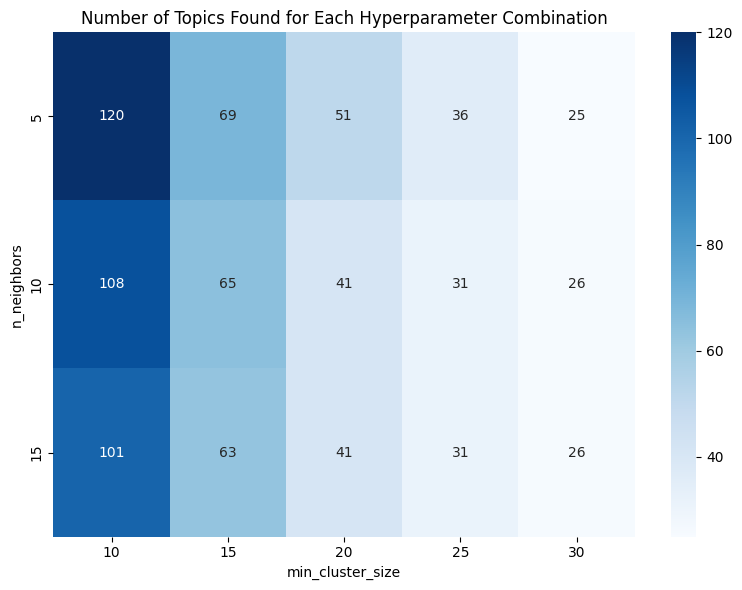

In [8]:
# ------------------------------------------------------------
# Plot Results as Heatmap
# ------------------------------------------------------------
pivot_table = results_df.pivot(index="n_neighbors", columns="min_cluster_size", values="n_topics")
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="Blues")
plt.title("Number of Topics Found for Each Hyperparameter Combination")
plt.xlabel("min_cluster_size")
plt.ylabel("n_neighbors")
plt.tight_layout()
plt.show()



In [9]:
# ------------------------------------------------
# More fine-tuned scan around promising min_cluster_size
# values and exploring min_dists settings
# ------------------------------------------------
from itertools import product

# Parameters to scan
min_cluster_sizes = [25, 28, 30]
umap_min_dists = [0.0, 0.1, 0.2]
n_neighbors = 10

# Create an empty list to collect results
results = []

# Loop through combinations
for min_cluster_size, umap_min_dist in product(min_cluster_sizes, umap_min_dists):
    print(f"Training model with min_cluster_size={min_cluster_size}, umap_min_dist={umap_min_dist}")
    
    # Define UMAP and HDBSCAN models
    umap_model = UMAP(
        n_neighbors=n_neighbors,
        n_components=5,
        min_dist=umap_min_dist,
        metric="cosine",
        random_state=42
    )

    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=5,
        metric="euclidean",
        cluster_selection_method='eom',
        prediction_data=True
    )

    # Train BERTopic
    topic_model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=custom_vectorizer,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        calculate_probabilities=True,
        verbose=True
    )
    
    topics, probs = topic_model.fit_transform(texts)
    n_topics = len(set(t for t in topics if t != -1))

    timestamp = datetime.datetime.now().strftime("%Y%m%d")
    model_name = f"bertopic_neighbors{n_neighbors}_cluster{min_cluster_size}_dist{umap_min_dist}_{timestamp}"
    topic_model.save(os.path.join(model_dir, model_name))
    
    # Record results
    results.append({
        "min_cluster_size": min_cluster_size,
        "umap_min_dist": umap_min_dist,
        "n_neighbors": n_neighbors,
        "n_topics": n_topics
    })

    print(f"Saved {model_name} with {n_topics} topics.")


2025-04-28 18:32:30,819 - BERTopic - Embedding - Transforming documents to embeddings.


Training model with min_cluster_size=25, umap_min_dist=0.0


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.90it/s]
2025-04-28 18:32:37,422 - BERTopic - Embedding - Completed ✓
2025-04-28 18:32:37,422 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:32:44,940 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:32:44,941 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:32:45,115 - BERTopic - Cluster - Completed ✓
2025-04-28 18:32:45,117 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:32:45,521 - BERTopic - Representation - Completed ✓
2025-04-28 18:32:45,758 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:32:46,246 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster25_dist0.0_20250428 with 31 topics.
Training model with min_cluster_size=25, umap_min_dist=0.1


Batches: 100%|██████████| 97/97 [00:07<00:00, 13.51it/s]
2025-04-28 18:32:53,514 - BERTopic - Embedding - Completed ✓
2025-04-28 18:32:53,515 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:33:01,060 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:33:01,061 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:33:01,212 - BERTopic - Cluster - Completed ✓
2025-04-28 18:33:01,214 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:33:01,613 - BERTopic - Representation - Completed ✓
2025-04-28 18:33:01,849 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:33:02,342 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster25_dist0.1_20250428 with 28 topics.
Training model with min_cluster_size=25, umap_min_dist=0.2


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.34it/s]
2025-04-28 18:33:09,199 - BERTopic - Embedding - Completed ✓
2025-04-28 18:33:09,199 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:33:16,808 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:33:16,808 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:33:16,971 - BERTopic - Cluster - Completed ✓
2025-04-28 18:33:16,973 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:33:17,394 - BERTopic - Representation - Completed ✓
2025-04-28 18:33:17,637 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:33:18,292 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster25_dist0.2_20250428 with 28 topics.
Training model with min_cluster_size=28, umap_min_dist=0.0


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.30it/s]
2025-04-28 18:33:25,168 - BERTopic - Embedding - Completed ✓
2025-04-28 18:33:25,168 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:33:32,758 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:33:32,759 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:33:32,922 - BERTopic - Cluster - Completed ✓
2025-04-28 18:33:32,924 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:33:33,361 - BERTopic - Representation - Completed ✓
2025-04-28 18:33:33,595 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:33:34,077 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster28_dist0.0_20250428 with 29 topics.
Training model with min_cluster_size=28, umap_min_dist=0.1


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.88it/s]
2025-04-28 18:33:40,687 - BERTopic - Embedding - Completed ✓
2025-04-28 18:33:40,687 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:33:48,312 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:33:48,312 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:33:48,465 - BERTopic - Cluster - Completed ✓
2025-04-28 18:33:48,467 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:33:48,855 - BERTopic - Representation - Completed ✓
2025-04-28 18:33:49,097 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:33:49,581 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster28_dist0.1_20250428 with 28 topics.
Training model with min_cluster_size=28, umap_min_dist=0.2


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.66it/s]
2025-04-28 18:33:56,289 - BERTopic - Embedding - Completed ✓
2025-04-28 18:33:56,290 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:34:03,807 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:34:03,808 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:34:03,965 - BERTopic - Cluster - Completed ✓
2025-04-28 18:34:03,967 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:34:04,359 - BERTopic - Representation - Completed ✓
2025-04-28 18:34:04,589 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:34:05,061 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster28_dist0.2_20250428 with 28 topics.
Training model with min_cluster_size=30, umap_min_dist=0.0


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.81it/s]
2025-04-28 18:34:11,702 - BERTopic - Embedding - Completed ✓
2025-04-28 18:34:11,702 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:34:19,238 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:34:19,239 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:34:19,394 - BERTopic - Cluster - Completed ✓
2025-04-28 18:34:19,396 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:34:19,787 - BERTopic - Representation - Completed ✓
2025-04-28 18:34:20,016 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:34:20,496 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster30_dist0.0_20250428 with 26 topics.
Training model with min_cluster_size=30, umap_min_dist=0.1


Batches: 100%|██████████| 97/97 [00:06<00:00, 15.01it/s]
2025-04-28 18:34:27,050 - BERTopic - Embedding - Completed ✓
2025-04-28 18:34:27,050 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:34:34,677 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:34:34,678 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:34:34,825 - BERTopic - Cluster - Completed ✓
2025-04-28 18:34:34,827 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:34:35,212 - BERTopic - Representation - Completed ✓
2025-04-28 18:34:35,439 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-28 18:34:35,916 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster30_dist0.1_20250428 with 27 topics.
Training model with min_cluster_size=30, umap_min_dist=0.2


Batches: 100%|██████████| 97/97 [00:06<00:00, 14.96it/s]
2025-04-28 18:34:42,491 - BERTopic - Embedding - Completed ✓
2025-04-28 18:34:42,492 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-28 18:34:50,008 - BERTopic - Dimensionality - Completed ✓
2025-04-28 18:34:50,008 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-28 18:34:50,159 - BERTopic - Cluster - Completed ✓
2025-04-28 18:34:50,160 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-28 18:34:50,547 - BERTopic - Representation - Completed ✓
2025-04-28 18:34:50,775 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Saved bertopic_neighbors10_cluster30_dist0.2_20250428 with 27 topics.


In [10]:
# After all models are trained, create a DataFrame
results_df = pd.DataFrame(results)

# Sort results for easier reading
results_df = results_df.sort_values(by=["min_cluster_size", "umap_min_dist"]).reset_index(drop=True)

# Show the table
results_df

,min_cluster_size,umap_min_dist,n_neighbors,n_topics
0,25,0.0,10,31
1,25,0.1,10,28
2,25,0.2,10,28
3,28,0.0,10,29
4,28,0.1,10,28
5,28,0.2,10,28
6,30,0.0,10,26
7,30,0.1,10,27
8,30,0.2,10,27


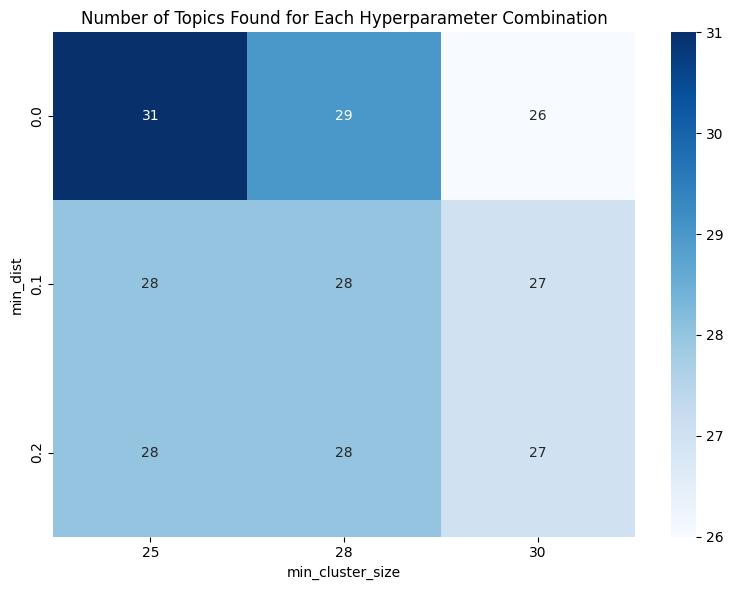

In [11]:
# ------------------------------------------------------------
# Plot Results as Heatmap
# ------------------------------------------------------------
pivot_table = results_df.pivot(index="umap_min_dist", columns="min_cluster_size", values="n_topics")
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="Blues")
plt.title("Number of Topics Found for Each Hyperparameter Combination")
plt.xlabel("min_cluster_size")
plt.ylabel("min_dist")
plt.tight_layout()
plt.show()